In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
tick = 0.1

trades_day_m2 = pd.read_csv('data/trades_round_1_day_-2.csv', delimiter=';')
trades_day_m1 = pd.read_csv('data/trades_round_1_day_-1.csv', delimiter=';')
trades_day_0 = pd.read_csv('data/trades_round_1_day_0.csv', delimiter=';')

prices_day_m2 = pd.read_csv('data/prices_round_1_day_-2.csv', delimiter=";")
prices_day_m1 = pd.read_csv('data/prices_round_1_day_-1.csv', delimiter=";")
prices_day_0 = pd.read_csv('data/prices_round_1_day_0.csv', delimiter=";")

day_m2 = prices_day_m2.merge(
    trades_day_m2, 
    left_on=['timestamp', 'product'], 
    right_on=['timestamp', 'symbol'], 
    how='inner'
).drop(columns=['symbol'])
day_m1 = prices_day_m1.merge(
    trades_day_m1, 
    left_on=['timestamp', 'product'], 
    right_on=['timestamp', 'symbol'], 
    how='inner'
).drop(columns=['symbol'])
day_0 = prices_day_0.merge(
    trades_day_0, 
    left_on=['timestamp', 'product'], 
    right_on=['timestamp', 'symbol'], 
    how='inner'
).drop(columns=['symbol'])

# df does not contain ALL data. Only the timestamps that are present in both trades and prices.
df = pd.concat([day_m2, day_m1, day_0]).reset_index()
print(df.head())

   index  day  timestamp           product  bid_price_1  bid_volume_1  \
0      0   -2          0  RAINFOREST_RESIN         9996             1   
1      1   -2          0  RAINFOREST_RESIN         9996             1   
2      2   -2          0              KELP         1998            26   
3      3   -2          0         SQUID_INK         1998            26   
4      4   -2        100         SQUID_INK         1999             5   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ...  ask_volume_2  \
0       9995.0          25.0          NaN           NaN  ...          25.0   
1       9995.0          25.0          NaN           NaN  ...          25.0   
2          NaN           NaN          NaN           NaN  ...           NaN   
3          NaN           NaN          NaN           NaN  ...           NaN   
4       1998.0          26.0          NaN           NaN  ...           NaN   

   ask_price_3  ask_volume_3  mid_price  profit_and_loss  buyer  seller  \
0          NaN   

`df` does not contain ALL data. Only the timestamps that are present in both trades and prices.

This is the model we need to fit. $\delta$ is the distance from the midprice standardised by the tick size. $\lambda$ is the trading intensity.

$$\lambda(\delta) = Ae^{-k\delta}$$

Apply logarithm and then perform linear regression.

$$\ln(\lambda(\delta)) = \ln(A) - k\delta$$

See https://hftbacktest.readthedocs.io/en/py-v2.0.0/tutorials/GLFT%20Market%20Making%20Model%20and%20Grid%20Trading.html

In [3]:
kelp = df[df['product'] == 'KELP']

# I think this might be wrong, not all trades are at the best price.
delta_bid = (kelp['mid_price'] - kelp['bid_price_1'])/tick
delta_ask = (kelp['ask_price_1'] - kelp['mid_price'])/tick

bins = np.sort(delta_bid.unique()).astype(int)
print(bins)

[ 5 10 15 20]


In [4]:
binned = pd.cut(
    x=kelp['quantity'],
    bins=np.insert(bins, 0, 0, axis=0),
    # retbins=True,
    labels=bins
)
binned = binned.value_counts() # type(binned) is pd.Series

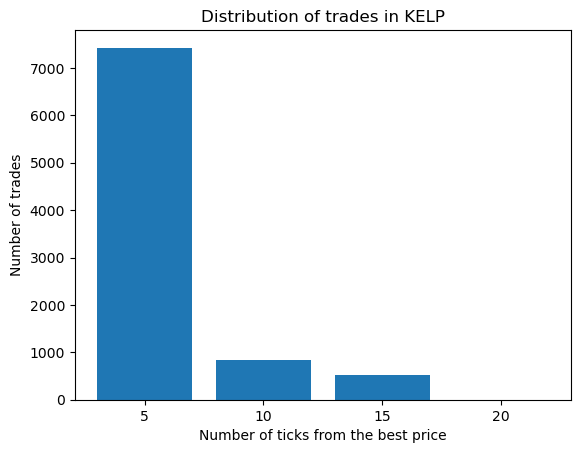

In [5]:
fig, ax = plt.subplots()
ax.bar(
    binned.index.astype(str),
    binned.values,
    width=0.8,
    align='center',
    tick_label=binned.index.astype(str)
)
ax.set_xlabel('Number of ticks from the best price')
ax.set_ylabel('Number of trades')
ax.set_title('Distribution of trades in KELP')
plt.show()

Now fit linear regression model!

In [6]:
from sklearn.linear_model import LinearRegression

Intercept: [9.95947107]
Coefficient: [[-0.26553443]]
R^2: 0.8813762267461166


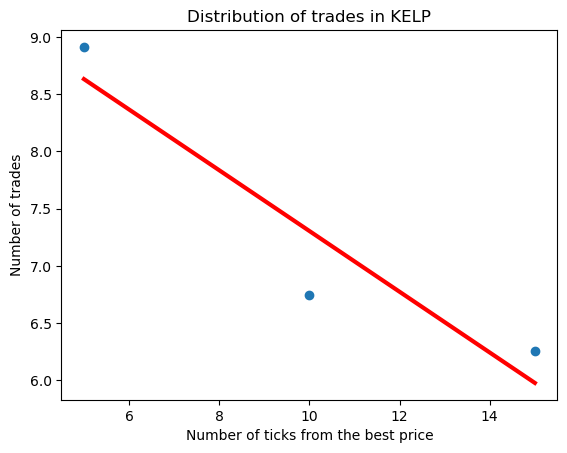

In [7]:
LR = LinearRegression()
X = np.array(binned.index[:-1]).reshape(-1, 1)
y = np.array(np.log(binned.values[:-1])).reshape(-1, 1)
LR.fit(X, y)
print(f'Intercept: {LR.intercept_}')
print(f'Coefficient: {LR.coef_}')
print(f'R^2: {LR.score(X, y)}')
plt.scatter(X, y)
plt.plot(X, LR.predict(X), color='red', linewidth=3)
plt.xlabel('Number of ticks from the best price')
plt.ylabel('Number of trades')
plt.title('Distribution of trades in KELP')
plt.show()